In [1]:
import pandas as pd
import pickle
import numpy as np
from datetime import datetime, timedelta
from EM import EM
import matplotlib.pyplot as plt
from plot import plot

### Things to be thinking about
* How to do quality control (check ups) for this model?

### TO DO
* Tidy up the analysis
    * coeff analysis for inr for different bin size
    * see if mse is bad for all signals
* think of ways to do individualize analysis

In [2]:
cdm_t = pd.read_pickle('../Data/cdm_t.pkl')
cdm_s = pd.read_pickle('../Data/cdm_s.pkl')

### Data Query Specification

In [3]:
# store signal names and their matching contexts
# key: signal name, e.g. inr
# value: (treatment_names, chronic_keywords, demographic_names)
# treatment_names: dict, key: treatment category e.g. anticoagulant, value: list of relevant fields, e.g. warfarin_dose
# chronic keywords: list, e.g. liver disease
# each signal is specified by a block of cell
signal_context = {}

In [4]:
signal_name = 'inr'

treatment_names = {}
treatment_names['nsaid'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['anticoagulant'] = ['warfarin_dose','heparin_dose','dabigatran_dose','edoxaban_dose','rivaroxaban_dose',
'apixaban_dose','enoxaparin_dose','dalteparin_dose','fondaparinux_dose']
treatment_names['transfusion_plasma'] = ['transfuse_plasma']
treatment_names['transfusion_platelets'] = ['transfuse_platelets']
treatment_names['aspirin'] = ['aspirin_dose']

# chronic dict is keyed on the keywords of the chronic conditions we care about
# the keywords are specified in chronic_keywords
# the value is a list of all the features in cdm_s that contain that keyword
chronic_keywords = ['liver_disease', 'sickle_cell']

demographic_names = ['age']

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [5]:
signal_name = 'lactate'
treatment_names = {}
treatment_names['ivf'] = ['crystalloid_fluid', 'crystalloid_fluid_order']
treatment_names['antibiotics'] = ['vancomycin_dose',
'piperacillin_tazobac_dose',
'ceftriaxone_dose',
'meropenem_dose',
'cefotaxime_dose', 'gentamicin_dose', 'ceftazidime_dose', 'amikacin_dose',
'amphotericin_b_ambisome_dose', 'amphotericin_b_fungizone_dose']
treatment_names['drugs_elevate_lactate'] = ['acetaminophen_dose',
 'epinephrine_dose',
 'propofol_dose',
 'theophylline_dose',
 'betaxolol_dose',
 'metformin_dose','albuterol_dose', 'salmeterol_dose']

#treatment_names['search'] = ['cocaine']

chronic_keywords = ['chronic_kidney', 'diabete', 'stroke', 'liver']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [6]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose','indomethacin_dose',
'ketorolac_dose','meloxicam_dose','naproxen_dose']
treatment_names['interference_drugs'] = ['dronedarone_dose', 'trimethoprim_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

#treatment_names['search'] = ['losartan']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'sickle_cell', 'renal', 'esrd', 'diabetes', 'heart_failure']

demographic_names = ['age', 'gender', 'admit_weight']

signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [7]:
signal_name = 'bun'
treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['drugs_increase'] = ['vancomycin_dose',
 'furosemide_dose',
 'carbamazepine_dose',
 'rifampin_dose',
 'hydrochlorothiazide_dose',
 'spironolactone_dose',
 'methotrexate_dose',
 'chlorothiazide_dose',
 'methyclothiazide_dose',
 'amphotericin_b_ambisome_dose',
 'amphotericin_b_fungizone_dose',
 'cefazolin_dose',
 'ceftriaxone_dose',
 'ceftazidime_dose',
 'cefuroxime_dose',
 'cefotaxime_dose']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'heart_failure', 'liver',
                    'heart_attack']

demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [8]:
signal_name = 'platelets'
treatment_names = {}
treatment_names['platelets_transfusion'] = ['transfuse_platelets']
treatment_names['ditp'] = ['ibuprofen_dose',
 'acetaminophen_dose',
 'ampicillin_dose',
 'heparin_dose',
 'vancomycin_dose',
 'piperacillin_tazobac_dose',
 'naproxen_dose']

chronic_keywords = ['liver', 'kidney', 'sickle_cell']
demographic_names = []
signal_context[signal_name] = (treatment_names, chronic_keywords, demographic_names)

In [9]:
signal_name = 'inr'
treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]

In [10]:
# helper to find the fields available in cdm_t corresponding to a list of potentially relevant fields
# specified in treatment_names['search']
all_features = cdm_t['fid'].unique()
def find_avai_feats():
    feat_list = []
    for feat in all_features:
        for name in treatment_names['search']:
            if name in feat:
                feat_list.append(feat)
    return feat_list

In [11]:
# fill in chronic name dict by finding all the relevant fields available in cdm_s for each chronic keyword
chronic_names = {}
all_chronic = cdm_s.loc[:, 'fid'].unique()
for name in chronic_keywords:
    chronic_names[name] = [s for s in all_chronic if name in s]

In [12]:
chronic_names

{'liver_disease': ['liver_disease_hist',
  'acute_liver_disease_hist',
  'acute_liver_disease_final_diag',
  'liver_disease_final_diag',
  'liver_disease_diag',
  'acute_liver_disease_diag',
  'acute_liver_disease_prob'],
 'sickle_cell': ['sickle_cell_trait_final_diag',
  'sickle_cell_trait_hist',
  'sickle_cell_wo_crisis_hist',
  'sickle_cell_crisis_final_diag',
  'sickle_cell_crisis_prob',
  'sickle_cell_wo_crisis_diag',
  'sickle_cell_wo_crisis_final_diag',
  'sickle_cell_trait_prob',
  'sickle_cell_crisis_diag',
  'sickle_cell_crisis_hist',
  'sickle_cell_wo_crisis_prob',
  'sickle_cell_trait_diag']}

### Preprocessing Parameters

### Notes on parameter choices
* cutoff = 5, to ensure most examples have more than one observation after binning, don't change
* max_missing_pct = .4, to ensure model performance, don't change
* bin_size = 12, lower has more granularity, but also more missingness (less available examples given the same max_missing_pct), set to 18 if 12 has too much missingness
* num_past_effect = 2: up to change (prior knowledge on how quickly effects manifest)
* num_training_obs = 4: if too little examples, can turn this down to 2 or 3

In [13]:
# the least number of signal observation a patient needs to have to be included
cutoff = 5

# bin_size is a offset alias used by the resample method
bin_size = '12H'
bin_size_num = 12

# the maximum percent of missingness allowed in observations for each individual
max_missing_pct = .4
# least number of training observations allowed for each individual
# (number of training observation is calculated based on the training pct specified below)
num_training_obs = 4

# number of past time points where treatment effects are considered
num_past_effects = 2

### Model Training Parameters

In [14]:
# EM Setting
training_pct = .8
single_effect = False

In [15]:
# put all the treatment names into a list to get the corresponding columns
treatment_list = []
for name in treatment_names.values():
    treatment_list.append(name)
# flatten the list
treatment_list = [item for sublist in treatment_list for item in sublist]

### Preprocessing

In [16]:
# df_t is part of the original dataframe that has all the ids who have measurements for the signal we are interested 
# in
signal = cdm_t.loc[cdm_t.loc[:, 'fid'] == signal_name, 'value']
ids = np.unique(cdm_t.loc[signal.index, 'enc_id'])
df_t = cdm_t.loc[cdm_t.loc[:, 'enc_id'].isin(ids), :]

In [17]:
# df_t is now part of the dataframe that contains only the rows with fid being either the signal or the treatments
df_t = df_t.loc[df_t.loc[:, 'fid'].isin(treatment_list + [signal_name]), :]

In [18]:
df_t.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence
477,3,8,2015-08-03 19:12:00+00,inr,0.9,1
607,3,10,2015-03-02 02:24:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2015-03-02 02:22:...",1
639,3,10,2015-03-02 08:18:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2015-03-02 02:22:...",1
667,3,10,2015-03-02 14:08:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2015-03-02 02:22:...",1
694,3,10,2015-03-02 21:25:00+00,ketorolac_dose,"{""dose"": 30.0, ""order_tsp"": ""2015-03-02 02:22:...",1
707,3,10,2015-03-03 02:41:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2015-03-02 02:22...",1
723,3,10,2015-03-03 04:24:00+00,inr,0.9,1
729,3,10,2015-03-03 06:34:00+00,acetaminophen_dose,"{""dose"": 1000.0, ""order_tsp"": ""2015-03-02 07:4...",1
731,3,10,2015-03-03 09:12:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2015-03-02 02:22...",1
753,3,10,2015-03-03 15:00:00+00,ibuprofen_dose,"{""dose"": 600.0, ""order_tsp"": ""2015-03-02 02:22...",1


In [19]:
# convert tsp field to python datetime object
df_t.loc[:, 'tsp'] = df_t.loc[:, 'tsp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S+%f'))
#df_t.loc[:, 'tsp'] = df_t.groupby('enc_id')['tsp'].apply(lambda x: x - x.iloc[0])

In [20]:
# for each id, adjust tsp so that time is zero for the first time the signal is measured
adjusted_time = df_t.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp'] - x.loc[x.loc[:, 'fid'] == signal_name, 'tsp'].iloc[0])
# adjusted_time is multiindexed, need to drop one level before assigning it to column tsp
adjusted_time.index = adjusted_time.index.droplevel()
df_t.loc[:, 'tsp_adjusted'] = adjusted_time

In [21]:
# cut the dataframe based on a cutoff number on the number of signal measurement a patient has
keep_index = df_t.groupby('enc_id')['fid'].filter(lambda x: x.value_counts().loc[signal_name] >= cutoff).index
df_t_cut = df_t.loc[keep_index].copy()

In [22]:
# number of patient available after the cutoff
df_t_cut['enc_id'].unique().shape[0]

2524

In [23]:
# delete rows whose adjusted time is less than the earliest treatment effect we wish to consider
df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(hours=-num_past_effects*bin_size_num), :]

In [24]:
# delete rows before the first observation
#df_t_cut = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]

#adjusted_time = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[:, 'tsp_adjusted']-x.loc[:, 'tsp_adjusted'].iloc[0])
#adjusted_time.index = adjusted_time.index.droplevel()
#df_t_cut.loc[:, 'tsp_adjusted'] = adjusted_time

In [25]:
df_t_cut.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence,tsp_adjusted
84737,3,1020,2014-04-24 23:02:00,heparin_dose,"{""dose"": 2000.0, ""order_tsp"": ""2014-04-23 17:4...",4,-1 days +03:50:00
84767,3,1020,2014-04-25 06:14:00,heparin_dose,"{""dose"": 2000.0, ""order_tsp"": ""2014-04-23 17:4...",4,-1 days +11:02:00
84779,3,1020,2014-04-25 10:03:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,-1 days +14:51:00
84786,3,1020,2014-04-25 12:46:00,heparin_dose,"{""dose"": 1500.0, ""order_tsp"": ""2014-04-23 17:0...",4,-1 days +17:34:00
84800,3,1020,2014-04-25 15:43:00,heparin_dose,"{""dose"": 15.0, ""order_tsp"": ""2014-04-25 15:39:...",4,-1 days +20:31:00
84804,3,1020,2014-04-25 18:35:00,warfarin_dose,"{""dose"": 10.0, ""order_tsp"": ""2014-04-25 15:44:...",1,-1 days +23:23:00
84810,3,1020,2014-04-25 19:12:00,inr,1.0,1,00:00:00
84829,3,1020,2014-04-26 01:51:00,inr,1.0,1,06:39:00
84831,3,1020,2014-04-26 02:50:00,heparin_dose,"{""dose"": 19.0, ""order_tsp"": ""2014-04-25 15:39:...",4,07:38:00
84848,3,1020,2014-04-26 07:58:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,12:46:00


In [26]:
%%capture
# create column for the signal
df_t_cut.loc[:, signal_name] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin([signal_name]), 'value']
df_t_cut.loc[:, signal_name] = df_t_cut.loc[:, signal_name].apply(lambda x: float(x))

In [27]:
%%capture
# create a column for each treatment category
# binarize
for category, names in treatment_names.items():
    df_t_cut.loc[:, category] = df_t_cut.loc[df_t_cut.loc[:, 'fid'].isin(names), 'value']
for treatment in treatment_names.keys():
    df_t_cut.loc[df_t_cut.loc[:, treatment].notna(), treatment] = 1
    df_t_cut.loc[:, treatment] = df_t_cut.loc[:, treatment].fillna(value = 0)

In [28]:
# for every patient, delete all rows after the last valid signal measurement 
df_t_cut = df_t_cut.groupby('enc_id').apply(lambda x: x.loc[x.index <= x.loc[:, signal_name].last_valid_index(), :]).reset_index(drop=True)

In [29]:
df_t_cut.head(10)

,dataset_id,enc_id,tsp,fid,value,confidence,tsp_adjusted,inr,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin
0,3,1020,2014-04-24 23:02:00,heparin_dose,"{""dose"": 2000.0, ""order_tsp"": ""2014-04-23 17:4...",4,-1 days +03:50:00,NaN,0,1,0,0,0
1,3,1020,2014-04-25 06:14:00,heparin_dose,"{""dose"": 2000.0, ""order_tsp"": ""2014-04-23 17:4...",4,-1 days +11:02:00,NaN,0,1,0,0,0
2,3,1020,2014-04-25 10:03:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,-1 days +14:51:00,NaN,0,0,0,0,1
3,3,1020,2014-04-25 12:46:00,heparin_dose,"{""dose"": 1500.0, ""order_tsp"": ""2014-04-23 17:0...",4,-1 days +17:34:00,NaN,0,1,0,0,0
4,3,1020,2014-04-25 15:43:00,heparin_dose,"{""dose"": 15.0, ""order_tsp"": ""2014-04-25 15:39:...",4,-1 days +20:31:00,NaN,0,1,0,0,0
5,3,1020,2014-04-25 18:35:00,warfarin_dose,"{""dose"": 10.0, ""order_tsp"": ""2014-04-25 15:44:...",1,-1 days +23:23:00,NaN,0,1,0,0,0
6,3,1020,2014-04-25 19:12:00,inr,1.0,1,00:00:00,1.0,0,0,0,0,0
7,3,1020,2014-04-26 01:51:00,inr,1.0,1,06:39:00,1.0,0,0,0,0,0
8,3,1020,2014-04-26 02:50:00,heparin_dose,"{""dose"": 19.0, ""order_tsp"": ""2014-04-25 15:39:...",4,07:38:00,NaN,0,1,0,0,0
9,3,1020,2014-04-26 07:58:00,aspirin_dose,"{""dose"": 325.0, ""order_tsp"": ""2014-04-23 17:42...",1,12:46:00,NaN,0,0,0,0,1


In [30]:
# put signals in bins
binned_signal = df_t_cut.loc[:, ['enc_id', 'tsp_adjusted', signal_name]].dropna().groupby('enc_id').apply(lambda x: x.loc[:, ['tsp_adjusted', signal_name]].resample(bin_size, on='tsp_adjusted', base=0).mean())
binned_signal.reset_index(level='enc_id', inplace=True)
new_times = binned_signal.index.get_level_values('tsp_adjusted')
binned_signal.loc[:, 'time'] = new_times
binned_signal.reset_index(drop=True, inplace=True)

In [31]:
binned_signal

,enc_id,inr,time
0,1020,1.000,0 days 00:00:00
1,1020,NaN,0 days 12:00:00
2,1020,2.600,1 days 00:00:00
3,1020,NaN,1 days 12:00:00
4,1020,6.500,2 days 00:00:00
5,1020,NaN,2 days 12:00:00
6,1020,NaN,3 days 00:00:00
7,1020,4.700,3 days 12:00:00
8,1020,2.400,4 days 00:00:00
9,1221,1.700,0 days 00:00:00


In [32]:
# seperate the rows with positive and negative time to different dataframe to do resampling

# every row with nonnegative time
df_t_pos = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] >= timedelta(), :]
# every row with nonpositive time
df_t_neg = df_t_cut.loc[df_t_cut.loc[:, 'tsp_adjusted'] <= timedelta(), :]

In [33]:
%%capture
# make all the negative time positive, so the largest value is the time point farthest out
# necessary because resampling starts from the smallest time, we want it to be zero
df_t_neg.loc[:, 'tsp_adjusted'] = df_t_neg.loc[:, 'tsp_adjusted'].apply(lambda x: -x)

In [34]:
# binned treatments for time points prior to the first signal observation
binned_treatment_prev = df_t_neg.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
binned_treatment_prev.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
binned_treatment_prev.fillna(0, inplace=True)
new_times = binned_treatment_prev.index.get_level_values('tsp_adjusted')
binned_treatment_prev.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = new_times

In [35]:
# for some patient there are no treatments before the first observation
# but to allow the model to work consistently, we add rows with all zeros to those patients
def add_rows_treatment(x):
    last_time = x.loc[:, 'time'].iloc[-1]
    while last_time < timedelta(hours=(num_past_effects-1)*bin_size_num):
        last_row = x.iloc[-1, :]
        new_last_time = last_time + timedelta(hours=bin_size_num)
        last_row.loc['time'] = new_last_time
        last_row.loc[list(treatment_names.keys())] = 0
        last_time = new_last_time
        x = x.append(last_row)
    return x

binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: add_rows_treatment(x))
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [36]:
# adjust time so that the farthest out time point is time zero
positive_time = binned_treatment_prev.groupby('enc_id').apply(lambda x: (x.loc[:, 'time'].iloc[-1]-x.loc[:, 'time']))
positive_time.reset_index(drop=True, inplace=True)
binned_treatment_prev.loc[:, 'time'] = positive_time

In [37]:
# flip row order so| time is in increasing order
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').apply(lambda x: x.iloc[::-1])
binned_treatment_prev.reset_index(drop=True, inplace=True)

In [38]:
# treatments prior to the first observation is stored seperatedly from those after
# so signals and treatments after the first observation can use the same starting time point
binned_treatment_prev

,enc_id,tsp_adjusted,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin,time
0,1020,20:10:00,0,1,0,0,0,00:00:00
1,1020,09:09:00,0,1,0,0,1,12:00:00
2,1221,03:42:00,0,0,0,0,0,00:00:00
3,1221,03:42:00,0,1,0,0,0,12:00:00
4,1319,00:00:00,0,0,0,0,0,00:00:00
5,1319,00:00:00,0,0,0,0,0,12:00:00
6,1330,00:00:00,0,0,0,0,0,00:00:00
7,1330,00:00:00,0,0,0,0,0,12:00:00
8,1337,00:00:00,0,0,0,0,0,00:00:00
9,1337,00:00:00,0,0,0,0,0,12:00:00


In [39]:
# resampling for treatments after the first signal observation
# the first time point for each patient is num_past_effects*bin_size_num
binned_treatment_post = df_t_pos.loc[:, ['enc_id', 'tsp_adjusted']+ list(treatment_names.keys())].groupby('enc_id').apply(lambda x: x.resample(bin_size, on='tsp_adjusted').max())
#binned_treatment_post.loc[:, 'enc_id'].fillna(method='bfill', inplace=True)
# some enc_id might be 0 if there is no any treatment available for that time interval
# but that's okay since we only need the treatment columns
binned_treatment_post.fillna(0, inplace=True)
new_time = binned_treatment_post.index.get_level_values('tsp_adjusted') #+ timedelta(hours=num_past_effects*bin_size_num)
binned_treatment_post.loc[:, 'time'] = new_time
binned_treatment_post.reset_index(drop=True, inplace=True)

In [40]:
binned_treatment_post

,enc_id,tsp_adjusted,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin,time
0,1020.0,0 days 07:38:00,0.0,1.0,0.0,0.0,0.0,0 days 00:00:00
1,1020.0,0 days 22:26:00,0.0,1.0,0.0,0.0,1.0,0 days 12:00:00
2,1020.0,1 days 11:22:00,0.0,0.0,0.0,0.0,0.0,1 days 00:00:00
3,1020.0,1 days 22:15:00,0.0,1.0,0.0,0.0,1.0,1 days 12:00:00
4,1020.0,2 days 11:50:00,0.0,0.0,0.0,0.0,0.0,2 days 00:00:00
5,1020.0,2 days 13:20:00,0.0,0.0,0.0,0.0,1.0,2 days 12:00:00
6,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,3 days 00:00:00
7,1020.0,3 days 21:50:00,0.0,1.0,0.0,0.0,1.0,3 days 12:00:00
8,1020.0,4 days 11:59:00,0.0,0.0,0.0,0.0,0.0,4 days 00:00:00
9,1221.0,0 days 06:03:00,0.0,1.0,0.0,0.0,0.0,0 days 00:00:00


In [41]:
%%capture
'''
# put the binned treatment together
binned_treatment_list = []
for i in np.unique(binned_signal.loc[:, 'enc_id']):
    prev = binned_treatment_prev.loc[binned_treatment_prev.loc[:, 'enc_id']==i, :]
    post = binned_treatment_post.loc[binned_treatment_post.loc[:, 'enc_id']==i, :]
    binned_treatment_list.append(pd.concat([prev, post]))

binned_treatment_combined = pd.concat(binned_treatment_list)
binned_treatment_combined.reset_index(drop=True, inplace=True)

# adjust time points for signal so that the first observation starts from time num_past_effects * bin_size_num
binned_signal.loc[:, 'time'] += timedelta(hours=num_past_effects*bin_size_num)

# for each id, signals for the first num_past_effects time points are nan
# those are used as placeholder so that the dimension of signal matrix matches that of the treatment matrix
def add_rows_signal(x):
    x = x.iloc[::-1]
    first_time = x.loc[:, 'time'].iloc[-1]
    while first_time > timedelta():
        new_first_time = first_time - timedelta(hours=bin_size_num)
        row = x.iloc[0]
        row[signal_name] = np.nan
        row['time'] = new_first_time
        first_time = new_first_time
        x = x.append(row)
    return x.iloc[::-1]

binned_signal = binned_signal.groupby('enc_id').apply(lambda x: add_rows_signal(x)).reset_index(drop=True)
'''

In [42]:
# contain binned signal and treatments starting from the first observation
# the first observation for each id is time zero
df_binned = pd.concat([binned_signal, binned_treatment_post.loc[:, list(treatment_names.keys())]], axis = 1)

In [43]:
df_binned

,enc_id,inr,time,nsaid,anticoagulant,transfusion_plasma,transfusion_platelets,aspirin
0,1020,1.000,0 days 00:00:00,0.0,1.0,0.0,0.0,0.0
1,1020,NaN,0 days 12:00:00,0.0,1.0,0.0,0.0,1.0
2,1020,2.600,1 days 00:00:00,0.0,0.0,0.0,0.0,0.0
3,1020,NaN,1 days 12:00:00,0.0,1.0,0.0,0.0,1.0
4,1020,6.500,2 days 00:00:00,0.0,0.0,0.0,0.0,0.0
5,1020,NaN,2 days 12:00:00,0.0,0.0,0.0,0.0,1.0
6,1020,NaN,3 days 00:00:00,0.0,0.0,0.0,0.0,0.0
7,1020,4.700,3 days 12:00:00,0.0,1.0,0.0,0.0,1.0
8,1020,2.400,4 days 00:00:00,0.0,0.0,0.0,0.0,0.0
9,1221,1.700,0 days 00:00:00,0.0,1.0,0.0,0.0,0.0


In [44]:
df_binned['enc_id'].unique().shape[0]

2524

In [45]:
# take only part of cdm_s that has the patient ids which we use in df_binned
df_s = cdm_s.loc[cdm_s.loc[:, 'enc_id'].isin(df_binned.loc[:, 'enc_id'].unique()), :]

In [46]:
# create dataframe containing each chronic conditions, binarize
df_static = pd.DataFrame()
for chronic, names in chronic_names.items():
    col = df_s.groupby('enc_id').apply(lambda x: x.loc[x.loc[:, 'fid'].isin(names), 'value'].any())
    df_static.loc[:, chronic] = col # to make sure index is correct
    df_static.loc[:, chronic] = np.where(col == False, 0, 1)

In [47]:
df_static

,liver_disease,sickle_cell
enc_id,,
1020,0,0
1221,0,0
1319,0,0
1330,0,0
1337,0,0
1575,0,0
1602,0,0
1793,0,0
1905,0,0


In [48]:
# add demographic information to df_static
for demo in demographic_names:
    col = df_s.groupby('enc_id').apply(lambda x: float(x.loc[x.loc[:, 'fid'] == demo, 'value'].values[0]))
    df_static.loc[:, demo] = col

In [49]:
df_static

,liver_disease,sickle_cell,age
enc_id,,,
1020,0,0,56.0
1221,0,0,89.0
1319,0,0,88.0
1330,0,0,90.0
1337,0,0,68.0
1575,0,0,82.0
1602,0,0,72.0
1793,0,0,80.0
1905,0,0,83.0


In [50]:
# remove individuals with observation missing pct larger than the threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: (np.where(x.loc[:, signal_name].isna())[0].shape[0]) / x.shape[0] < max_missing_pct)
# remove individuals with num training obs less than the a threshold
df_binned = df_binned.groupby('enc_id').filter(lambda x: int(np.where(np.invert(np.isnan(x.loc[:, signal_name])))[0].shape[0]*training_pct) >= num_training_obs)
# the number of ids available for training
num_unique_ids = np.unique(df_binned.loc[:, 'enc_id']).shape[0]
num_unique_ids

485

In [51]:
# overall percentage of missing observations after removal
np.where(df_binned.loc[:, signal_name].isnull())[0].shape[0]/df_binned.shape[0]

0.33421809334218094

In [52]:
# also remove the individuals with high missing pct and small number of training obs
# from df_static and binned_treatment_prev
df_static = df_static.loc[np.unique(df_binned.loc[:, 'enc_id']), :]
binned_treatment_prev = binned_treatment_prev.groupby('enc_id').filter(lambda x: x.loc[:, 'enc_id'].iloc[0] in np.unique(df_binned.loc[:, 'enc_id']))

### Data analytics after Preprocessing

In [53]:
# part of df_binned of patients who have at least one treatment given
df_binned_with_treatment = df_binned.groupby('enc_id').filter(lambda x: np.nonzero(x.loc[:, list(treatment_names.keys())].apply(lambda y: np.count_nonzero(y)))[0].shape[0]!=0)
df_binned_with_treatment['enc_id'].unique().shape

(473,)

(array([73., 72., 69., 84., 69., 45., 28., 15.,  7.,  9.,  5.,  3.,  2.,
         3.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.981 , 1.2868, 1.5926, 1.8984, 2.2042, 2.51  , 2.8158, 3.1216,
        3.4274, 3.7332, 4.039 , 4.3448, 4.6506, 4.9564, 5.2622, 5.568 ,
        5.8738, 6.1796, 6.4854, 6.7912, 7.097 ]),
 <a list of 20 Patch objects>)

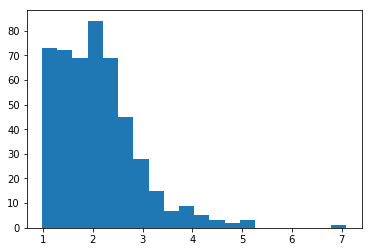

In [54]:
# the mean of signal values for each individual
signal_mean = df_binned.groupby('enc_id').apply(lambda x: np.mean(x[signal_name].values[np.where(np.invert(np.isnan(x[signal_name])))[0]]))
plt.hist(signal_mean, bins=20)

In [55]:
# patients with no treatment given
no_treatment = df_binned.groupby('enc_id').filter(lambda x: np.nonzero(x.loc[:, list(treatment_names.keys())].apply(lambda y: np.count_nonzero(y)))[0].shape[0]==0)
# standard deviation of signal values for patients with no treatment given
signal_std_no_treatment = no_treatment.groupby('enc_id').apply(lambda x: np.std(x[signal_name]))
# number of patients with no treatment given
signal_std_no_treatment.shape[0]

12

0.3157293997192503

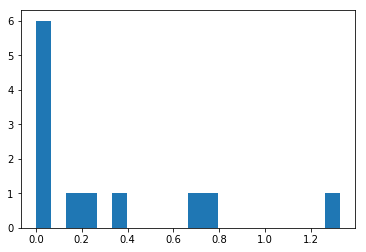

In [56]:
plt.hist(signal_std_no_treatment, bins=20)
# mean of the std
# should approx. transition noise?
np.mean(signal_std_no_treatment)

In [57]:
# for a given treatment time point, find the time point of the most recent observation PRIOR to 
# the treatment time point
def find_most_recent_obs_before_treatment(treatment_time, obs_times):
    min_index = np.argmin(np.absolute(obs_times-treatment_time))
    if obs_times[min_index] >= treatment_time:
        min_index -= 1
    return obs_times[min_index]

In [58]:
# percentage of decreasing (or increasing) effect of a single treatment at a single past time point e.g. the second
# day before among treatment given to all patients in df
def single_treatment_single_effect(df, treatment, past_time_point, decrease=False):
    patients = df['enc_id'].unique()
    total_num_effect = 0 # total number of treatment that has the desired effect
    # total number of treatment being considered, i.e. at the given past time point for a valid signal measurement
    total_num = 0
    for patient in patients:
        df_patient = df.loc[df['enc_id']==patient]
        treatment_time = np.nonzero(df_patient[treatment])[0]
        treatment_effect = []
        # time points w/ valid observation
        obs_times = np.where(np.invert(np.isnan(df_patient[signal_name].values)))[0]
        # for each observation, if there is a treatment given at the time point in question
        # the treatment effect is estimated by the difference between the current observation
        # and the MOST RECENT observation PRIOR to the time point when the treatment is given
        for i in obs_times:
            curr_obs = df_patient[signal_name].values[i]
            if i-past_time_point in treatment_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   :
                prev_obs_time = find_most_recent_obs_before_treatment(i-past_time_point, obs_times)
                prev_obs = df_patient[signal_name].values[prev_obs_time]
                treatment_effect.append(curr_obs-prev_obs)
                #print('obs time {}'.format(i))
                #print('treatment effect {}'.format(curr_obs-prev_obs))
        treatment_effect = np.array(treatment_effect)
        if decrease:
            total_num_effect += np.where(treatment_effect < 0)[0].shape[0]
        else:
            total_num_effect += np.where(treatment_effect > 0)[0].shape[0]
        total_num += treatment_effect.shape[0]
    if total_num == 0:
        return np.nan
    else:
        return total_num_effect / total_num

In [59]:
# run single_treatment_single_effect on a list of treatments for all of num_past_effects
def multiple_treatment_multiple_effect(df, treatments, decrease=False):
    for treatment in treatments:
        for i in range(1, num_past_effects+1):
            pct = single_treatment_single_effect(df, treatment, i, decrease)
            if decrease:
                effect = 'decreasing'
            else:
                effect = 'increasing'
            print('percentage of {} that has {} effect between the past {} and {} hrs: {}'.format
                  (treatment, effect, (i-1)*bin_size_num, i*bin_size_num, pct))

In [60]:
#multiple_treatment_multiple_effect(df_binned_with_treatment, ['diuretic', 'nephrotoxic_drugs', 'ace_i', 'arb', 
#                                                              'interference_drugs'], decrease=False)
#multiple_treatment_multiple_effect(df_binned_with_treatment, ['dialysis', 'interference_drugs'], decrease=True)

### Convert to np.array for Model Use

In [61]:
# maximum number of bins for an individual
# necessary if convert dataframe to np array
max_num_bins = int(max(df_binned.loc[:, 'time']) / timedelta(hours=bin_size_num)) + 1

In [62]:
max_num_bins

31

In [63]:
# turn static features into np array
c_mtx = df_static.values

In [64]:
# create matrix storing the signal observations
# shape is (number of patient * max_num_bins)
y_list = []
df_binned.groupby('enc_id').apply(lambda x: y_list.append(x.loc[:, signal_name].values))
# for some reason the first group always got appended twice to the list, so delete one
y_list.pop(0)
y_mtx = np.full((len(y_list), max_num_bins), np.nan)
for i, y in enumerate(y_list):
    y_mtx[i, :y.shape[0]] = y

In [65]:
# create matrix storing treatment (after the first observation) information
# shape is (number of patients * max_num_bins * number of treatment categories)
x_list = []
df_binned.groupby('enc_id').apply(lambda x: x_list.append(x.loc[:, list(treatment_names.keys())].values))
x_list.pop(0)
X_mtx = np.zeros((len(x_list), max_num_bins, len(treatment_names.keys())))
for i, x in enumerate(x_list):
    X_mtx[i, :x.shape[0], :] = x

In [66]:
# create matrix storing treatment (before the first observation) information
# shape is (number of patients * num_past_effects * number of treatment categories)
x_prev_list = []
binned_treatment_prev.groupby('enc_id').apply(lambda x: x_prev_list.append(x.loc[:, list(treatment_names.keys())].values))
x_prev_list.pop(0)
X_prev_mtx = np.zeros((len(x_prev_list), num_past_effects, len(treatment_names.keys())))
for i, x in enumerate(x_prev_list):
    X_prev_mtx[i, :x.shape[0], :] = x

In [67]:
np.savez('../Data/'+signal_name+'_preprocessed_data', y_mtx=y_mtx, X_mtx=X_mtx, X_prev_mtx=X_prev_mtx, c_mtx=c_mtx)

In [68]:
y_mtx.shape

(485, 31)

### Model Training

In [69]:
%%time
em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = X_prev_mtx, single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
43 iterations before params converge
CPU times: user 29.1 s, sys: 6.69 ms, total: 29.2 s
Wall time: 29.1 s


In [70]:
np.sum(em.mu_smooth) / np.count_nonzero(em.mu_smooth)

2.1045985688901294

In [71]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state mean: {}'.format(em.init_z))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise (std): {}'.format(np.sqrt(em.sigma_1)))
print('observation noise (std): {}'.format(np.sqrt(em.sigma_2)))

Coefficient for nsaid: [0.00729265 0.10083136]
Coefficient for anticoagulant: [-0.53739519 -0.28843527]
Coefficient for transfusion_plasma: [ 0.07175756 -0.07878854]
Coefficient for transfusion_platelets: [-0.82909029 -0.69233128]
Coefficient for aspirin: [-0.05402798 -0.02496115]
Coefficient for liver_disease: 0.0030612742935978493
Coefficient for sickle_cell: -0.3609382136765579
Coefficient for age: 0.005433229080539707
initial state mean: 2.109641313052897
initial state variance: 0.004349953558399127
transition noise (std): 0.3176611044556879
observation noise (std): 1.064659746789027


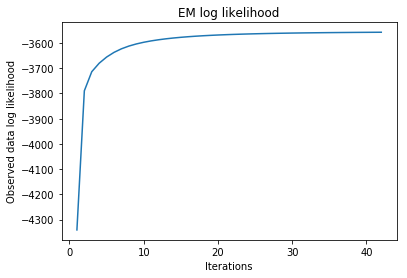

In [72]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

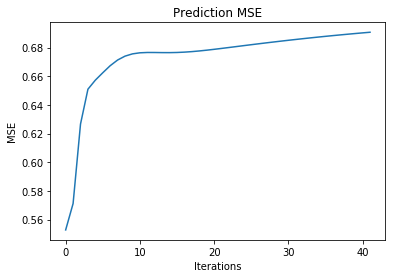

In [73]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

In [74]:
# return the index in array a whose element is not in b
def not_in(a, b):
    index = []
    for i, ele in enumerate(a):
        if ele not in b:
            index.append(i)
    return np.array(index)

have_treatment_index = not_in(df_binned['enc_id'].unique(), no_treatment['enc_id'].unique())

In [75]:
# return the index (in np array) of patients who have a particular type of treatment
def have_index(treatment):
    no_treatment = df_binned.groupby('enc_id').filter(lambda x: np.count_nonzero(x[treatment]) == 0)['enc_id'].unique()
    return not_in(df_binned['enc_id'].unique(), no_treatment)

Patient 132


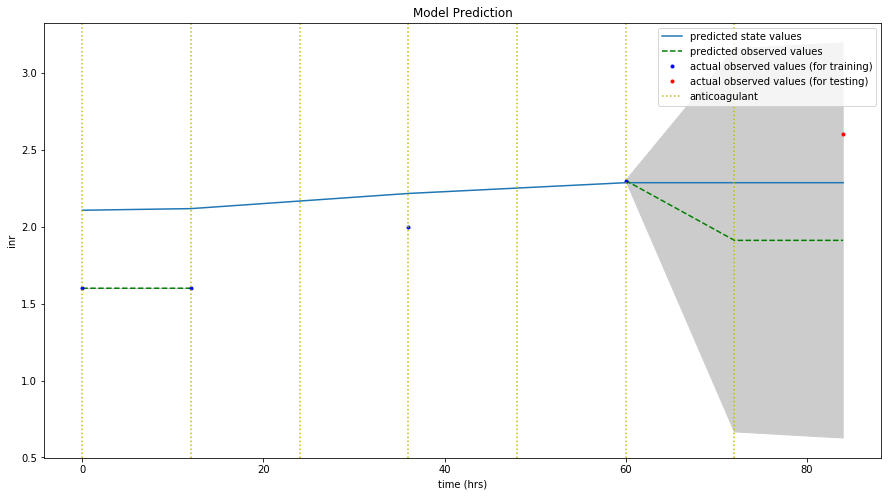

Patient 330


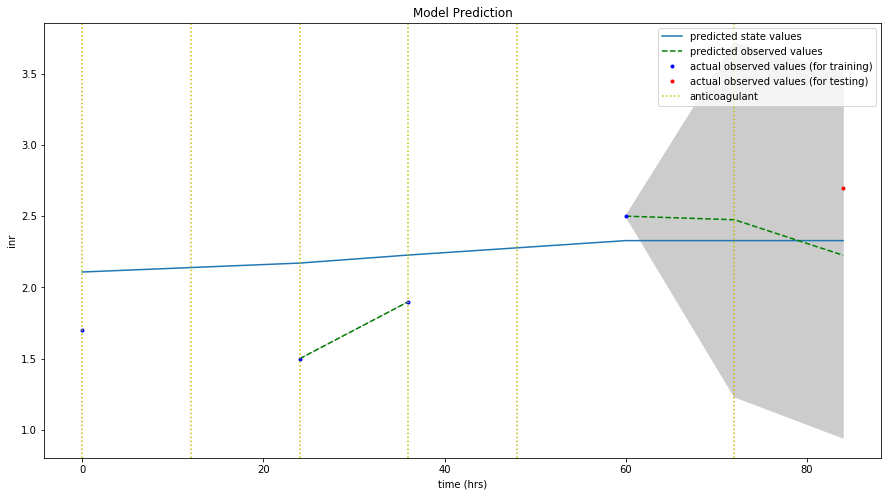

Patient 237


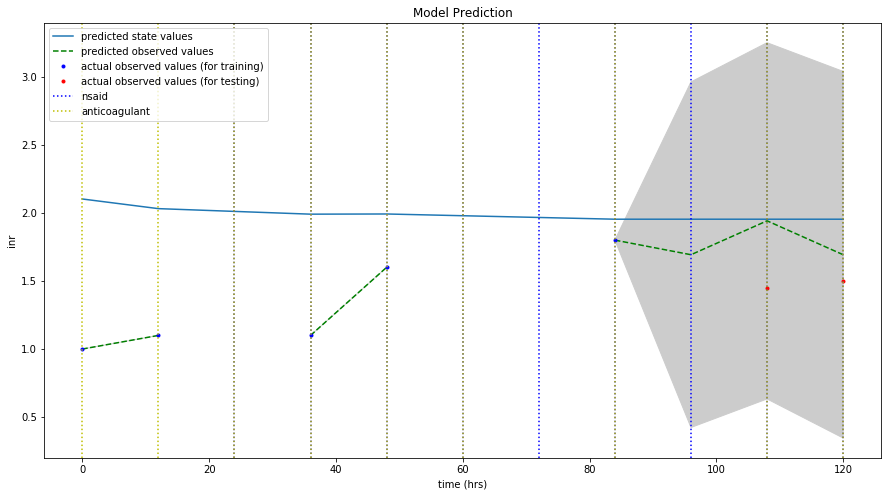

Patient 331


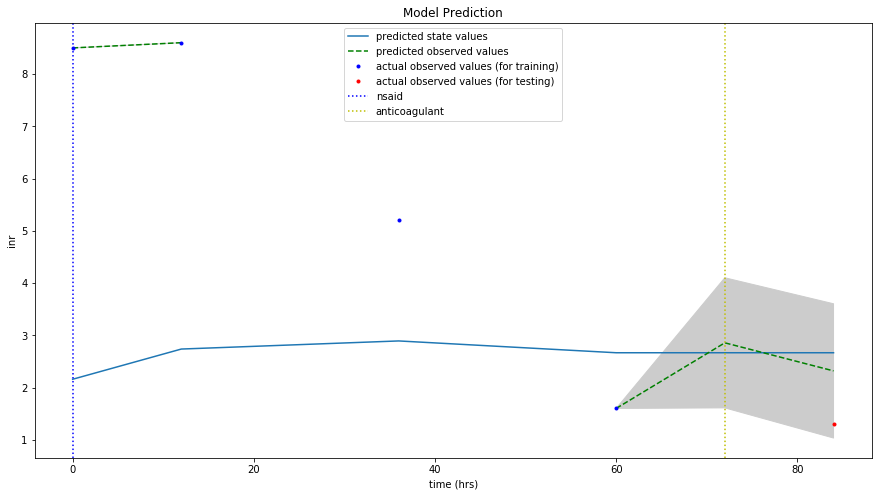

Patient 335


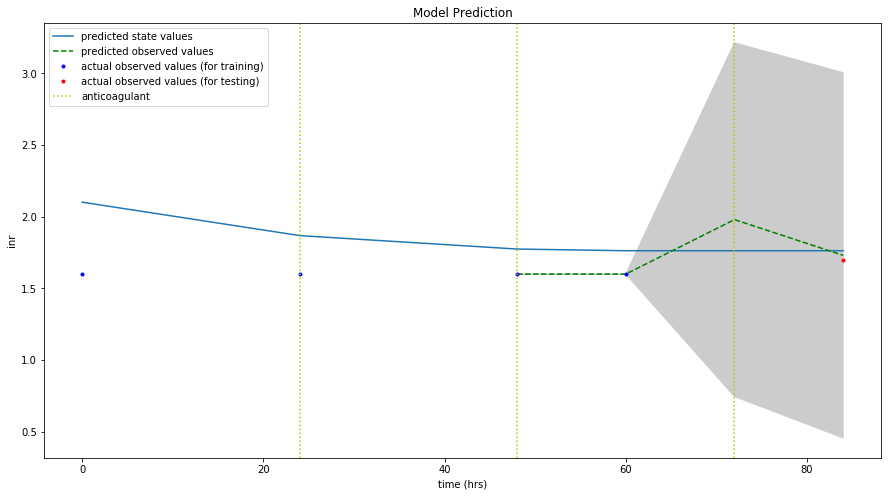

Patient 327


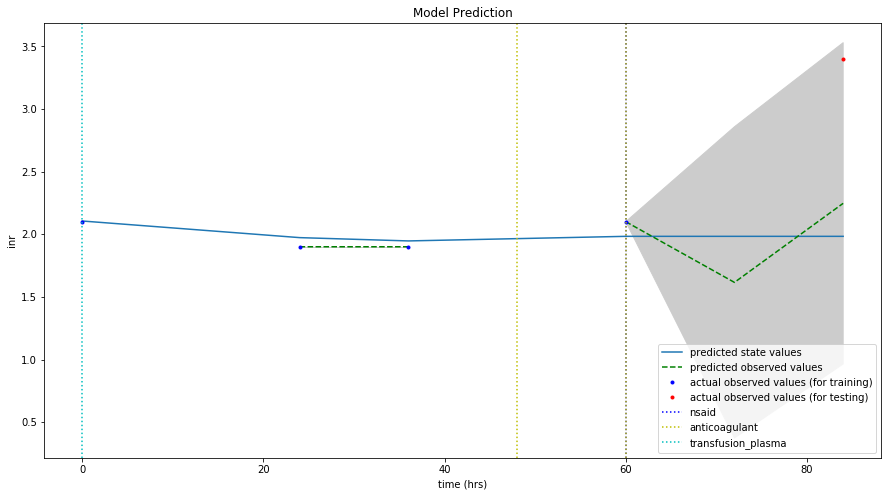

Patient 58


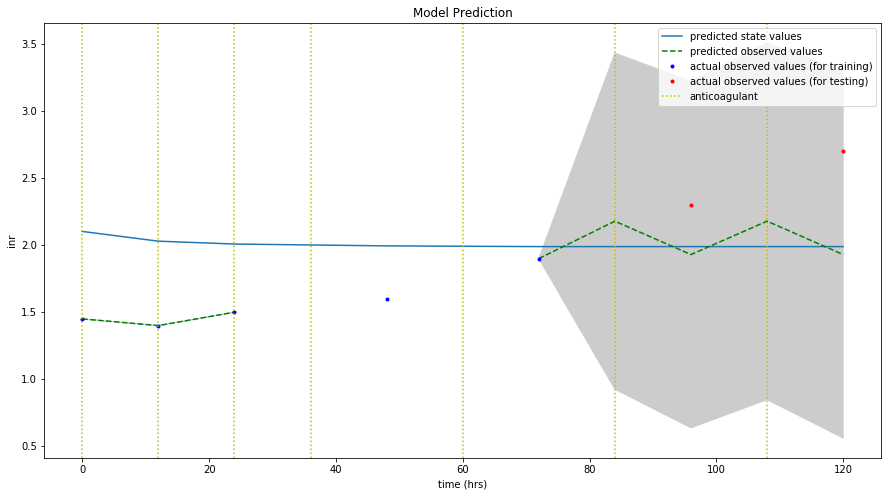

Patient 339


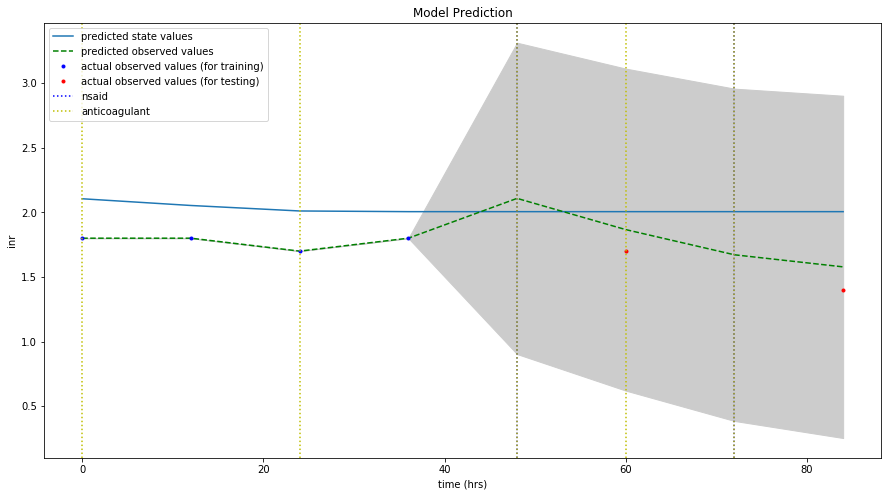

Patient 293


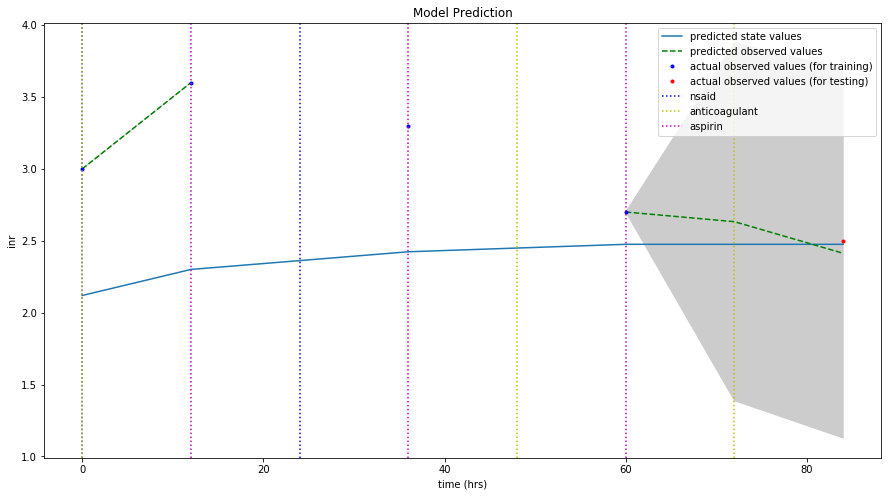

Patient 262


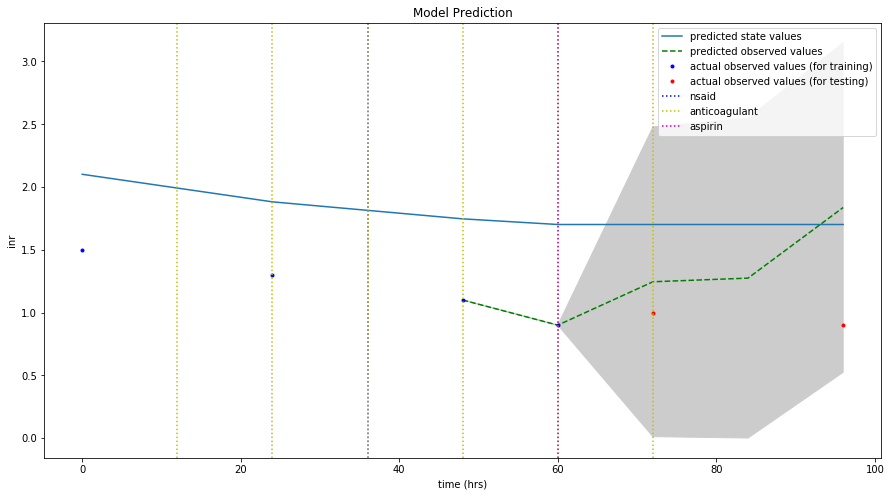

Patient 442


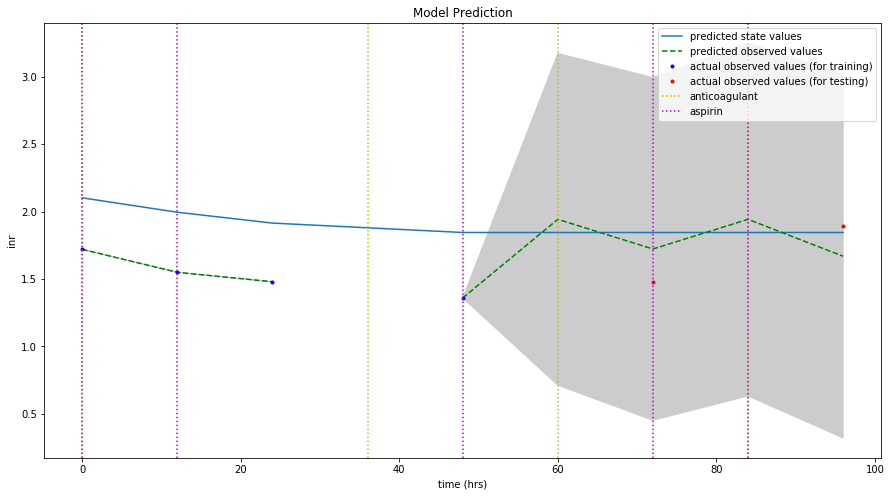

Patient 465


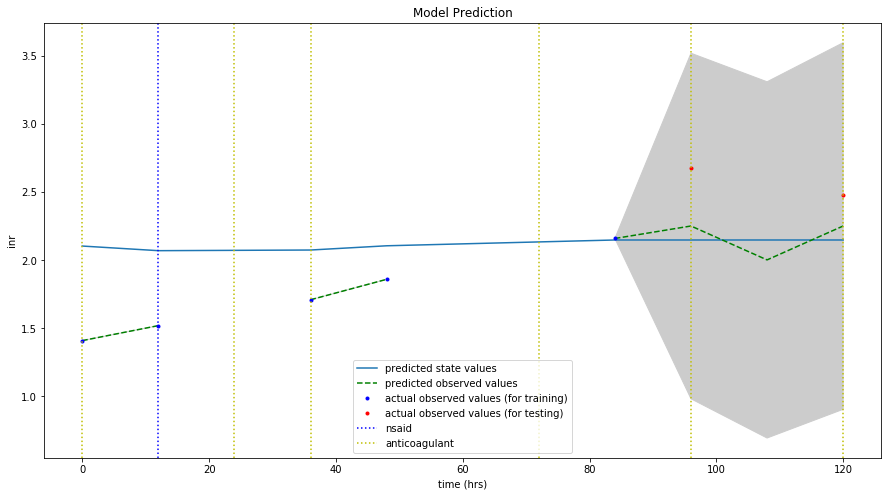

Patient 6


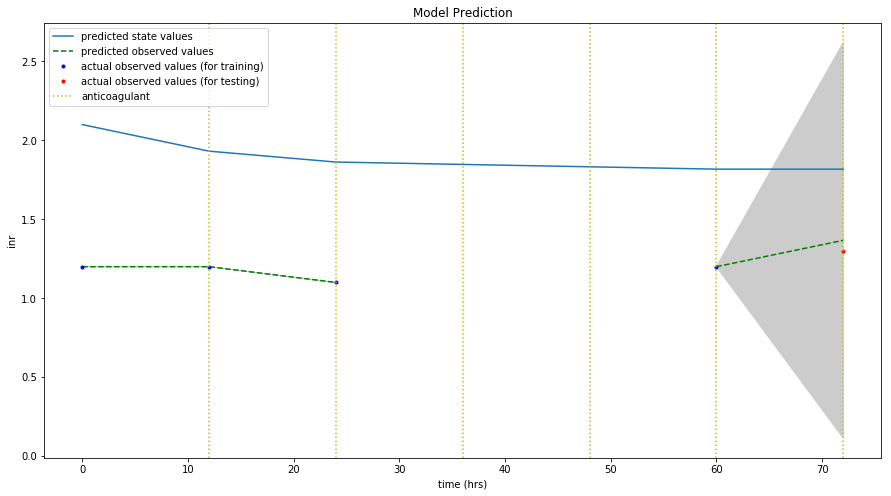

Patient 337


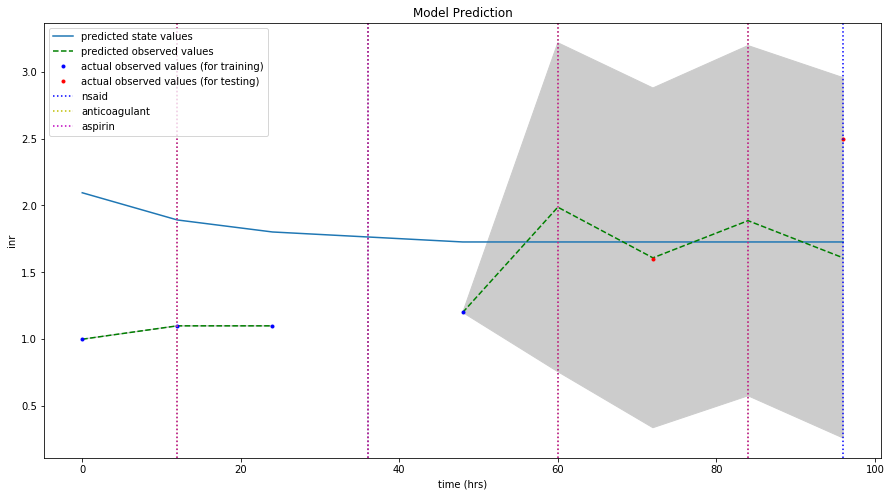

Patient 24


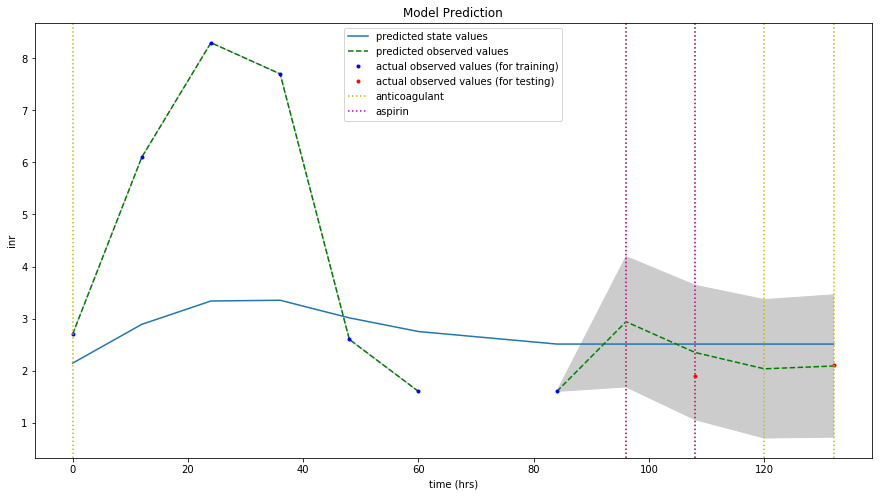

Patient 30


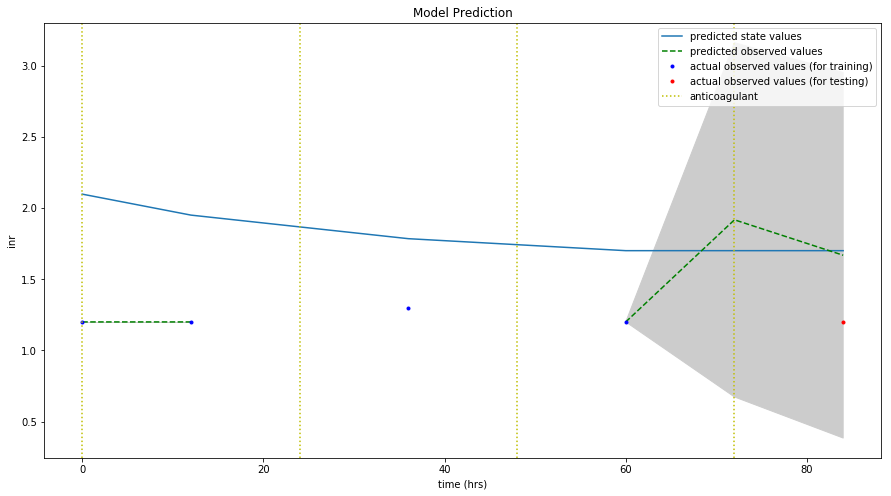

Patient 216


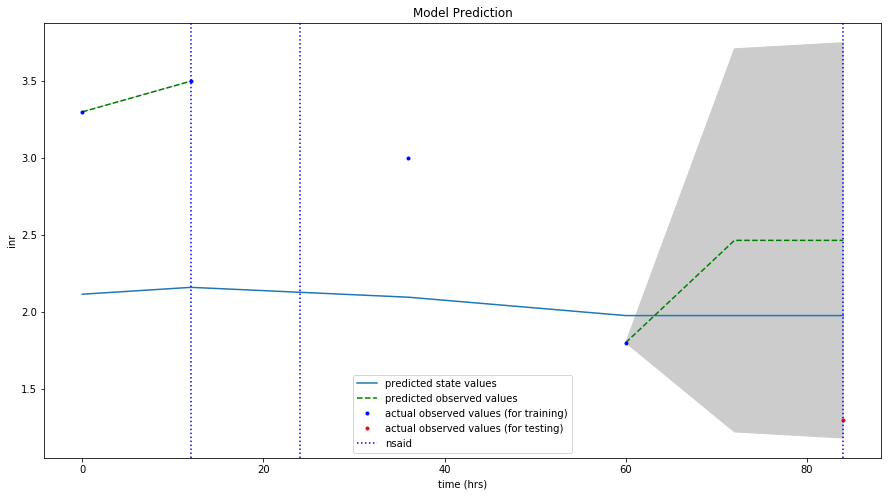

Patient 468


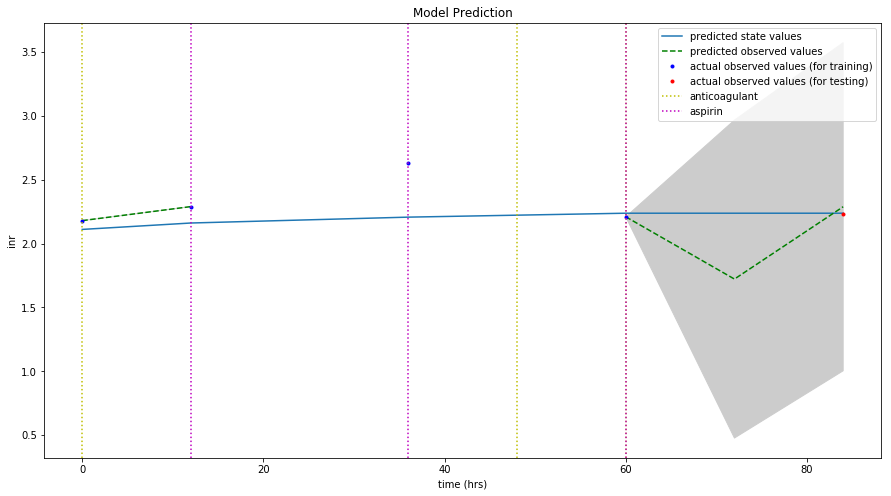

Patient 207


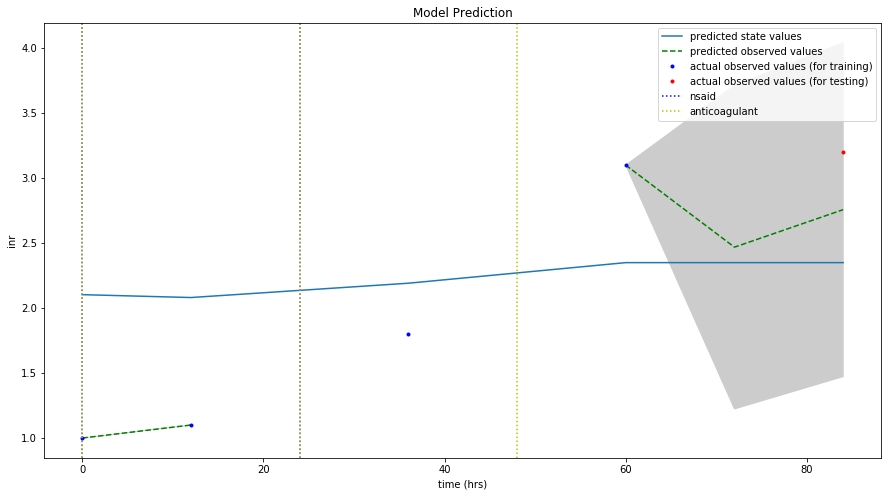

Patient 57


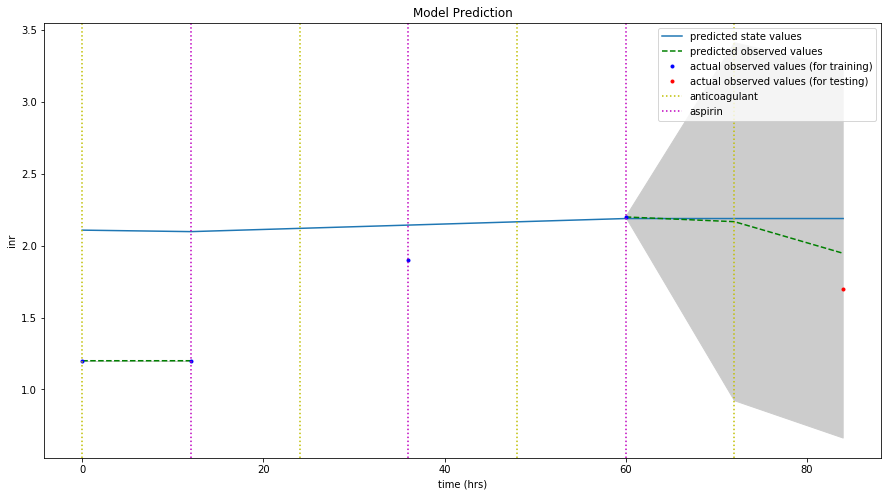

In [76]:
random_patients = np.random.choice(have_treatment_index, size=20, replace=False)
for i in random_patients:
    plot(em, i, bin_size_num, signal_name, treatment_types=list(treatment_names.keys()))

## General concerns and observations
* Correlation among variables (especially chronics)
    * heart failure has some correlation w/ ckf, age usually correlates w/ other chronic conditions, how would the coefficients be affected? could the effect of one variable be explained away by another one that's correlated w/ it?
* For many signals, MSE shows an overall increasing trend 
* Noise
    * observation noise is always about twice as large as the transition noise
    * average std of patients w/o treatments is reasonably close to transition noise
* Coefficients
    * Usually identifies the ones w/ largest effect e.g. dialysis and chronic conditions. 
    * doesn't identify clear effects for drugs that may have effects on signal
* estimated state mean outside the normal range of signal value
    * within normal range: platelet
    * outside normal range: BUN, creatinine, lactate, inr
    * estimated state mean usually larger than normal range (in particular, initial state mean estimate is always larger than normal value) 
    * a problem of using population coefficients? since the state mean should represent the signal value w/o any external effect only if the coefficients correctly account for the effects for each individual
    * could this be a check for the correctness of the coeff estimates?

## INR
### Concerns
* average state mean is 2.1, which is within the therepeutic range (2-3), but higher than normal (1.1)

## Platelets
### Concerns
* platelets transfusion has very negative coefficients
    * looking at the plots: for a number of plots, platelet counts doesn't seem to show obvious increase after transfusion 

### Things to note
* MSE has overall increasing trend 
* obs noise is about double transition noise
* ditp, kidney failure has virtually no effect
* liver large negative, sickle cell large positive, as expected
* average state mean is around 200, within the normal range (100-450)

### Things tried
* bin_size = 6: try to capture effects of platelet transfusion 
    * much smaller population (200), still negative coeffs

## BUN

### Concerns
* MSE has increasing trend overall
* the average of state mean 26 is not within the 'normal' range 7-20
    * could be because initial state mean is high (29), possibly affected by those inidividuals who are sicker and have higher BUN overall
    * could also indicate population level coefficients is not sufficient to explain the effect of treatments and chronics on individuals

### Things to note
* Most coefficients are as expected
    * dialysis clear decrease (~-10), effects most clear in the first 24 hrs
    * kidney related chronic conditions clear increase
* Diuretics and drugs that may increase BUN are small negative coefficients (between -3 and 0)
* heart failure is small positive (3), liver failure small negative (-2)
* heart attack is moderate negative (-6)
* obs noise is still about double the transition noise (std)

### Things tried
* above results are from default setting (2300 examples)


## Creatinine
### Concerns
* the average variance for patients w/o treatment (.24) is not the same as the sum of estimated transition and observation variance (.3 + 1.1). It is pretty close the just the estimated transition variance.
* the average of state mean (3) is way outside the normal range (around 1)

### Things to note
* Coefficients that seem good
    * dialysis: large decrease, decreasing effect
    * kidney condition, sickle cell, renal insufficiency all positive
    * esrd: large positive (too large?)
    * gender: if 1 is male, more muscle mass, should be positive
    * interference drug: decrease, then reversible increase, as much as .4-.5
* Coefficients that are not so good
    * nephrotoxic, diuiretic, ace_i, arb: should be positive, but a mix of negative and positive
        * could be due to heterogeneity i.e. treatment doesn't have much effect on population as a whole
        
### Things tried
* run the model only on patients w/ hf
    * dialysis coefficients are flipped, otheres didn't change
    * population is drastically reduced
* less number of previous effects (2 instead of 4)
    * not much changed: nephrotoxic, ace-i still all negative; acb all positive
* don't use diabete and hf as features 
    * not much changed
* don't use age and weigths as features
    * gender becomes negative, the negative ones become more negative


## Lactate

### Concerns
* lactate order differentiates plasma and whole blood lactate. Does it affect the value of measurements much?
* lactate level usually elevates due to tissue hypoperfusion caused by underlying infection. if treatments are applied to treat the underlying infection directly, should we consider those treatments in all the signals we model? (since infection is a common cause for all the signals to change, treatments aimed at the underlying infection should affect level of al the signals)
* MSE curve always seems to be increasing
* estimated state mean 4 is out of normal range 0.5-1.5

### Things to note
* Coefficients that seem good
    * antibiotics: steady negative
    * liver: positive
* Coefficients that are not so good
    * ivf: 1st coeff becomes positive (when example size decreases) could be due to ivf have Ringer's lactate?
    * drugs: 2nd coeff always negative
    * ckd, diabete, stroke: change between positive and negative (when example size changes)
* relatively large noises compared to other signals
    * transition: 2-3, observation: 4-6

### Things tried
* change the number of training obs each example needs to have in order to increase number of examples
    * default setting gives 150 examples
    * (num_train_obs = ) 1: 450 examples, ckd negative, 2nd coeff for drugs negative, others as expected (diabete and stroke are small positive relative to others)
    * 2: 360 examples, same as 1, except diabete and stroke also negative
    * 3: 210 examples, same as 2, but stroke becomes positive
* change bin size to 18
    * ckd negative, others as expected

### Future Improvements
* for now, signals and treatments are stored as np array whose shape is determined by the maximum number of bins an individual has. This is to accomodate the existing code in EM.py, but the resulting matrix has lots of extra nans(in the case of signal) and zeros(in the case of treatments), which could be address by changing the data structure used in the EM.py code